## Deep Mutational Scan - Dataset

This dataset was assambled by Moritz Schäfer and the mutational information can be found in the file: 'cr9114_processed.csv' and the wildtype structure in 'cr9114_newcal1999_processed_relaxed.pdb'

In [1]:
import os
import pandas as pd
import warnings
import numpy as np
from pathlib import Path
warnings.filterwarnings("ignore")
from abag_affinity.utils.config import read_yaml, get_data_paths, get_resources_paths

In [2]:
config = read_yaml("../../abag_affinity/config.yaml")

summary_path, pdb_path = get_resources_paths(config, "DMS")
summary_df = pd.read_csv(summary_path)

In [17]:
structure_file = "cr9114_newcal1999_processed_relaxed.pdb"

chain_id2protein = {"c": "antibody", "a": "antigen", "b": "antigen"}

distance_cutoff = 5

interface_hull_size = 10

In [18]:
summary_df

,Unnamed: 0,genotype,h1_repa,h1_repb,h1_repc,h1_mean,h1_sem,h3_repa,h3_repb,h3_repc,h3_mean,h3_sem,fluB_repa,fluB_repb,fluB_repc,fluB_mean,fluB_sem,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,som_mut,h_mutations,scfv_mutations
0,0,1001110010000101,9.502127,9.499467,9.452164,9.484586,0.011476,6.000000,6.000000,6.000000,6.000000,0.000000,6.0,6.0,6.0,6.0,0.0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,1,7,FH28S;IH51S;TH56S;AH57T;KH73I;RH86T;YH105S,FC164S;IC187S;TC192S;AC193T;KC209I;RC222T;YC241S
1,1,1111110011011,9.526711,9.446817,9.319445,9.430991,0.042677,6.000000,6.000000,6.000000,6.000000,0.000000,6.0,6.0,6.0,6.0,0.0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,1,1,10,IH51S;TH56S;AH57T;NH58A;TH70S;KH73I;SH76N;SH83...,IC187S;TC192S;AC193T;NC194A;TC206S;KC209I;SC21...
2,2,1111110010011111,9.522475,9.556415,9.412129,9.497006,0.030798,6.719267,6.789486,6.699885,6.736213,0.019246,6.0,6.0,6.0,6.0,0.0,1,1,1,1,1,1,0,0,1,0,0,1,1,1,1,1,12,FH28S;SH29N;SH30N;IH51S;TH56S;AH57T;KH73I;SH76...,FC164S;SC165N;SC166N;IC187S;TC192S;AC193T;KC20...
3,3,1011111110101110,9.520731,9.557455,9.420888,9.499691,0.028852,6.000000,6.000000,6.000000,6.000000,0.000000,6.0,6.0,6.0,6.0,0.0,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,0,12,FH28S;SH30N;IH51S;TH56S;AH57T;NH58A;TH70S;KH73...,FC164S;SC166N;IC187S;TC192S;AC193T;NC194A;TC20...
4,4,1111101010000111,9.346955,9.398311,9.396946,9.380737,0.011947,6.000000,6.000000,6.000000,6.000000,0.000000,6.0,6.0,6.0,6.0,0.0,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,10,FH28S;SH29N;SH30N;IH51S;TH56S;NH58A;KH73I;RH86...,FC164S;SC165N;SC166N;IC187S;TC192S;NC194A;KC20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,65531,100010110100,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,NaN,6.000000,0.000000,6.0,6.0,NaN,6.0,0.0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,5,TH56S;KH73I;TH75S;SH76N;RH86T,TC192S;KC209I;TC211S;SC212N;RC222T
65532,65532,10100000110110,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,NaN,6.000000,0.000000,6.0,6.0,6.0,6.0,0.0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,6,SH30N;TH56S;TH75S;SH76N;RH86T;YH94F,SC166N;TC192S;TC211S;SC212N;RC222T;YC230F
65533,65533,10100010111000,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,6.000000,6.000000,0.000000,6.0,6.0,NaN,6.0,0.0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,6,SH30N;TH56S;KH73I;TH75S;SH76N;SH83N,SC166N;TC192S;KC209I;TC211S;SC212N;SC219N
65534,65534,10100110001000,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,6.000000,6.000000,0.000000,6.0,6.0,NaN,6.0,0.0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,5,SH30N;TH56S;TH70S;KH73I;SH83N,SC166N;TC192S;TC206S;KC209I;SC219N


In [19]:
summary_df = summary_df[~summary_df["scfv_mutations"].isna()]

unique_mutations = summary_df[~summary_df["scfv_mutations"].str.contains(";")]["scfv_mutations"].tolist()

In [20]:
all_mutations = [(mut[1], mut[2:-1]) for mut in unique_mutations]
all_mutations

[('C', '209'),
 ('C', '210'),
 ('C', '165'),
 ('C', '187'),
 ('C', '241'),
 ('C', '194'),
 ('C', '212'),
 ('C', '193'),
 ('C', '164'),
 ('C', '211'),
 ('C', '222'),
 ('C', '166'),
 ('C', '230'),
 ('C', '219'),
 ('C', '192'),
 ('C', '206')]

## Interface analysis

Get residues that are present in the interface (AB residue <10A distance to AG residue)

In [21]:
from abag_affinity.utils.pdb_processing import get_residue_infos, get_distances, get_residue_edge_encodings, get_atom_encodings, get_atom_edge_encodings
from abag_affinity.utils.pdb_reader import read_file

In [22]:
structure, header = read_file("struct", os.path.join(pdb_path, structure_file))

structure_info, residue_infos, residue_atom_coordinates = get_residue_infos(structure, header, chain_id2protein)

atom_encodings, _ = get_atom_encodings(residue_infos, structure_info, chain_id2protein)

distances, closest_residue_indices = get_distances(residue_infos, residue_distance=False, ca_distance=False)

A = get_atom_edge_encodings(distances, atom_encodings, distance_cutoff=5)

In [23]:
residue_distances, _ = get_distances(residue_infos, residue_distance=True, ca_distance=False)

contact_map = residue_distances < distance_cutoff
interface_distances = np.zeros_like(residue_distances)
interface_distances[contact_map] = residue_distances[contact_map]

#### Visualize Interface contacts

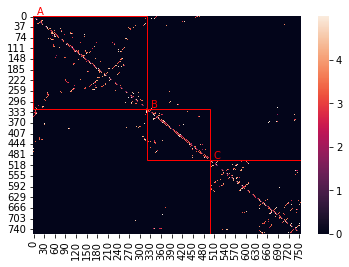

In [24]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

chain_lengths = []
for chain in structure.get_chains():
    residue_list = list(chain.get_residues())
    chain_name = chain.id
    chain_lengths.append((len(residue_list), chain_name))

ax = sns.heatmap(interface_distances)

total_length = 0
for length, chain_name in chain_lengths:
    plt.text(total_length + 10, total_length - 5, chain_name, color="r")
    rect = Rectangle((total_length, total_length), length, length, linewidth=1, edgecolor='r', facecolor='none')
    total_length += length
    ax.add_patch(rect)

plt.show()

## Filter mutations in interface

In [25]:
interface = A[0, :, :] - A[2, :, :]
interface_atoms = np.where(interface > 0.001)[0]

interface_atoms = np.unique(interface_atoms)

interface_hull = np.where(A[3, interface_atoms, :] < interface_hull_size)
interface_hull_atoms = np.unique(interface_hull[1])

In [26]:
interface_residues = set()

for atom in interface_hull_atoms:
    interface_residues.add(atom_encodings[atom][-1])

In [27]:
chain_offset = {
    "A": 0,
    "B": 321,
    "C": 499
}

In [28]:
mutations_in_interface = []

for mutation in unique_mutations:
    chain = mutation[1]
    chain_idx = int(mutation[2:-1])
    
    total_idx = chain_offset[chain] + chain_idx
    
    if total_idx in interface_residues:
        mutations_in_interface.append(mutation)

In [29]:
mutations_in_interface

['KC209I',
 'SC210F',
 'SC165N',
 'IC187S',
 'YC241S',
 'NC194A',
 'SC212N',
 'AC193T',
 'FC164S',
 'TC211S',
 'SC166N',
 'TC192S',
 'TC206S']

In [34]:
mutations_not_in_interface = set(unique_mutations) - set(mutations_in_interface)
mutations_not_in_interface

{'RC222T', 'SC219N', 'YC230F'}

In [30]:
def only_interface_mutations(row):
    mutations = row["scfv_mutations"].split(";")
    for mutation in mutations:
        if mutation not in mutations_in_interface:
            return False
    
    return True

summary_df["mutations_in_interface"] = summary_df.apply(only_interface_mutations, axis=1)

In [31]:
cleaned_df = summary_df[summary_df["mutations_in_interface"]].copy()
cleaned_df = cleaned_df[["h1_mean", "scfv_mutations"]]

In [32]:
data_path, [pdb_path] = get_data_paths(config, "DMS")

Path(pdb_path).mkdir(exist_ok=True, parents=True)

cleaned_df.to_csv(data_path, index=False)

In [36]:
len(cleaned_df)

8191